In [1]:
import gzip
import json
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import csv
from html.parser import HTMLParser
from io import StringIO
import re
import pandas as pd
import random
from random import sample
import os.path
import torch
from torch.utils.data import Dataset
from ast import literal_eval
import transformers
from tqdm.auto import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import copy
from sklearn.manifold import TSNE
np.set_printoptions(linewidth=120)
pd.set_option('display.width', 120)

In [2]:
pip install torchmetrics

In [3]:
from torchmetrics.functional import r2_score

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
# Prameter counting: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [6]:
print(f"Is CUDA supported by this system?  {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
torch_device = torch.device("cuda")
print(torch_device)

Is CUDA supported by this system?  True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA L4
cuda


In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [8]:
class ReviewDataset(Dataset):
    def __init__(self, dataset_fp, tokenizer, tokenize_df=None, mapping_fp=None):
        print("Reading data...")
        data_raw_df = pd.read_csv(dataset_fp, converters={'review_data': literal_eval})
        data_raw_df.reset_index()
        assert set(data_raw_df.columns) == {'user_id', 'review_data', 'review_count'}

        self.tokenizer = tokenizer

        self.data_product_rating_reviews = dict()
        self.product_mapping = dict()
        self.products = set()

        # Grab information
        print("Tokenizing data...")
        if tokenize_df is not None and os.path.exists(tokenize_df):
            print("Attempting to load from filepath...")
            self.data_tokenized_df = pd.read_csv(tokenize_df, converters={'review_tokens': literal_eval, 'review_numtokens': literal_eval, 'review_count': literal_eval})
            if mapping_fp is not None and os.path.exists(mapping_fp):
                print("Loading json into dictionary...")
                with open(mapping_fp, 'r', encoding="utf_8") as fp:
                    self.product_mapping = json.load(fp)
            else:
                self.data_tokenized_df.progress_apply(self._finduniqueprod, axis=1)
        else:
            self.data_tokenized_df = data_raw_df.apply(self._tokenize, axis=1)

            # Product list. Will use embedding to represent the product list.
        product_list = sorted(list(self.products))
        for product_idx in range(len(product_list)):
            product_id = product_list[product_idx]
            self.product_mapping[product_id] = product_idx

    def _finduniqueprod(self, row):
        review_data = row["review_tokens"]
        for review in review_data:
            product_id, product_rating, product_review = review
            self.products.add(product_id)
        return None

    def _tokenize(self, row):
        new_row = pd.Series()
        user_id = row["user_id"]
        review_data = row["review_data"]
        review_count = row["review_count"]

        tokenized_review_data = []
        tokenized_review_numtokens = []
        for review in review_data:
            product_id, product_rating, product_review = review

            self.products.add(product_id)
            # Collect data on products and their reviews
            if product_id not in self.data_product_rating_reviews.keys():
                self.data_product_rating_reviews[product_id] = []
            self.data_product_rating_reviews[product_id].append((product_rating, product_review))

            # Tokenize the data
            review_tokenized = self.tokenizer(product_review, truncation=True)["input_ids"]
            new_tuple = (product_id, product_rating, review_tokenized)
            tokenized_review_data.append(new_tuple)
            tokenized_review_numtokens.append(len(review_tokenized))

        new_row["user_id"] = user_id
        new_row["review_tokens"] = tokenized_review_data
        new_row["review_numtokens"] = tokenized_review_numtokens
        new_row["review_count"] = review_count
        return new_row

    def get_review_count():
        review_count = dict()
        for product_id in self.data_product_rating_reviews.keys():
            review_count[product_id] = len(self.data_product_rating_reviews[product_id])
        return review_count

    def __len__(self):
        return len(self.data_tokenized_df)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            stp = idx.step
            if stp is None:
                stp = 1
            return pd.DataFrame([self.__getitem__(i) for i in range(idx.start, idx.stop, stp)])
        if isinstance(idx, list):
            return pd.DataFrame([self.__getitem__(i) for i in idx])
        data_row = self.data_tokenized_df.iloc[idx]
        return data_row

In [9]:
# Need cased as reference to games occurs.
transformer_name = "bert-base-cased"
tf_tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
all_dataset = ReviewDataset("/content/drive/My Drive/CS577 Project/Preprocessing/dataset_operating.csv", tf_tokenizer, "/content/drive/My Drive/CS577 Project/" + transformer_name + "-tokenized_dataset.csv", "/content/drive/My Drive/CS577 Project/" + transformer_name + "-tokenized_mapping.json")
if not os.path.exists("/content/drive/My Drive/CS577 Project/" + transformer_name + "-tokenized_dataset.csv"):
    all_dataset.data_tokenized_df.to_csv("/content/drive/My Drive/CS577 Project/" + transformer_name + "-tokenized_dataset.csv", index=False)
if not os.path.exists("/content/drive/My Drive/CS577 Project/" + transformer_name + "-tokenized_mapping.json"):
    with open("/content/drive/My Drive/CS577 Project/" + transformer_name + "-tokenized_mapping.json", 'w', encoding="utf_8") as fp:
        json.dump(all_dataset.product_mapping, fp)

Reading data...
Tokenizing data...
Attempting to load from filepath...
Loading json into dictionary...


In [11]:
def get_collate_fn(tokenizer, product_mapping, sample_size=None):
    pad_index = tokenizer.pad_token_id
    def collate_fn(batch):
        # Get the max number of tokens IN THE BATCH
        max_batch_tokens = -1
        for bat in batch:
            token_count = max(bat["review_numtokens"])
            max_batch_tokens = max(max_batch_tokens, token_count)

        # Given a batch, we modify it via padding and whatnot and randomly sample.
        user_id_list = []
        y_product_id_list = []
        y_product_rating_list = []

        x_product_id_list = [[] for i in range(sample_size-1)]
        x_product_rating_list = [[] for i in range(sample_size-1)]
        x_product_review_list = [[] for i in range(sample_size-1)]
        x_product_numtokens_list = [[] for i in range(sample_size-1)]

        for bat in batch:
            # Randomly smaple the sample size if not none
            smple, counts = zip(*random.sample(list(zip(bat["review_tokens"], bat["review_numtokens"])), sample_size))
            smple = list(smple)

            # We have a sample. For the first element we will choose as our target y variable.
            user_id_list.append(bat["user_id"])
            y_product_id_list.append(product_mapping[smple[0][0]])
            y_product_rating_list.append(smple[0][1])

            # For the other samples, we need to collect them. We will have a list of lists storing product id, rating, review.
            # These store everything for the current sample. Should be same size as the sample_size.

            for i in range(1, len(smple)):
                review_sample_idx = i-1 # This is the index in x_product-id_list, etc to store the resulting data

                product_id_mapped = product_mapping[smple[i][0]]

                product_rating =  smple[i][1]

                token_list = smple[i][2]

                # Padding needs to occur for the batch for one review_sample_idx. For simplicity's sake, we use the entire batch's max token size
                # to determine how much to pad.
                token_padded_np = np.full(max_batch_tokens, pad_index, dtype=int)
                token_padded_np[:counts[i]] = token_list

                # We have ids, ratings, and the reviews for the batch. Now we store this (while distinguishing this!)
                x_product_id_list[review_sample_idx].append(product_id_mapped)
                x_product_rating_list[review_sample_idx].append(product_rating)
                x_product_review_list[review_sample_idx].append(token_padded_np)
                x_product_numtokens_list[review_sample_idx].append(len(token_list))

        ret_batch = dict()
        ret_batch["user_ids"] = user_id_list
        ret_batch["batch_size"] = len(y_product_id_list)
        ret_batch["x_size"] = sample_size-1
        ret_batch["y_product_id"] = np.asarray(y_product_id_list, dtype=int)  # The product id of the product whose rating we want to predict. Expected size: batch_size.
        ret_batch["y_product_rating"] = np.asarray(y_product_rating_list, dtype=float) # The rating of the product the person did. Expected size: batch_size.


        ret_batch["x_product_id"] = np.asarray(x_product_id_list, dtype=int) # The product ids. Shape is (sample_size-1, batch_size)
        ret_batch["x_product_rating"] = np.asarray(x_product_rating_list, dtype=float) # The rating numbers. Shape is (sample_size-1, batch_size)
        ret_batch["x_product_review"] = np.asarray(x_product_review_list, dtype=int) # The reviews, padded. Shape is (sample_size-1, batch_size, max_token_length)
        ret_batch["x_product_numtokens"] = np.asarray(x_product_numtokens_list, dtype=int)# The original token length. Shape is (sample_size-1, batch_size)

        # batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return ret_batch
    return collate_fn

In [12]:
def print_batch(batch, tokenizer, mapping):
    inv_mapping = dict(zip(mapping.values(), mapping.keys()))

    for review_idx in range(batch["x_size"]):
        print("Review Index:", review_idx)
        product_ids = batch["x_product_id"][review_idx]
        product_ratings = batch["x_product_rating"][review_idx]
        product_reviews = batch["x_product_review"][review_idx]
        for batch_idx in range(batch["batch_size"]):
            product_id = inv_mapping[product_ids[batch_idx]]
            product_rating = product_ratings[batch_idx]
            product_review = product_reviews[batch_idx]
            product_review_text = tokenizer.convert_ids_to_tokens(product_review, skip_special_tokens=True)
            print("Batch:", batch_idx, "ProductID:", product_id, "Rating:", product_rating, "\n", '  '.join(product_review_text))

In [13]:
seed = 42
random.seed(42)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

class ReviewNetwork(torch.nn.Module):
    def __init__(self, product_count, transformer_name, torch_device, dropout=0.5, review_hiddensize=200, allreview_hiddensize=500, embed_size=200, review_context_size=5, tune=False):
        super().__init__()
        # One transformer, one embedding layer. Applied onto every one. To generate the hidden outputs.
        self.torch_device = torch_device
        self.transformer = transformers.AutoModel.from_pretrained(transformer_name)
        self.padtoken = self.transformer.config.pad_token_id

        if tune:
            for parameter in self.transformer.parameters():
                parameter.requires_grad = False
        self.product_embedding = torch.nn.Embedding(num_embeddings=product_count, embedding_dim=embed_size)

        self.review_context_size = review_context_size

        # Plan: Concat transformer final hidden and embedding result. Feed into NN, then all into one NN.
        transformer_hidden_dim = self.transformer.config.hidden_size

        # Total size for one review: Transformer Output + Embed Size + Rating. Intent is to train representation of Review with Product with Rating.
        transform_embed_concat_size = transformer_hidden_dim + embed_size + 1
        self.review_rep_fc1 = torch.nn.Linear(in_features=transform_embed_concat_size, out_features=review_hiddensize)
        self.review_rep_fc2 = torch.nn.Linear(in_features=review_hiddensize, out_features=review_hiddensize)

        # All Five combined dim size plus the target product embedding
        input_total_size = self.review_context_size * review_hiddensize + embed_size

        # Idea: Learn representation of five reviews together.
        self.all_review_fc1 = torch.nn.Linear(in_features=input_total_size, out_features=allreview_hiddensize)
        self.all_review_fc2 = torch.nn.Linear(in_features=allreview_hiddensize, out_features=allreview_hiddensize)

        # Final output(regression)
        self.output_fc = torch.nn.Linear(in_features=allreview_hiddensize, out_features=1)

        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, batch):
        # Batch is already constructed for inputs.
        # Verify that batch's input data is correct.
        batch_size = batch["batch_size"]
        y_product_ids = torch.Tensor(batch['y_product_id']).to(torch.int32).to(self.torch_device)
        y_product_ids = y_product_ids.reshape(y_product_ids.shape[0], 1)

        y_product_embedding = self.product_embedding(y_product_ids).squeeze()

        if batch_size == 1:
            y_product_embedding = torch.unsqueeze(y_product_embedding, 0)


        module_outputs_list = []
        # Loop through each review
        for review_idx in range(self.review_context_size):
            x_product_ids = torch.Tensor(batch['x_product_id'][review_idx]).to(torch.int32).to(self.torch_device)
            x_product_ids = x_product_ids.reshape(x_product_ids.shape[0], 1)

            x_product_ratings = torch.Tensor(batch['x_product_rating'][review_idx]).to(torch.float32).to(self.torch_device)
            x_product_ratings = x_product_ratings.reshape(x_product_ratings.shape[0], 1)

            x_product_reviews = torch.Tensor(batch['x_product_review'][review_idx]).to(torch.int32).to(self.torch_device)
            x_product_token_counts = torch.Tensor(batch['x_product_numtokens'][review_idx]).to(torch.int32)

            # Generate attention mask from num_tokens
            attention_mask = torch.zeros(x_product_reviews.shape).to(self.torch_device)
            for i in range(batch_size):
                attention_mask[i][0:x_product_token_counts[i]] = 1

            # Apply embeddings to batch of product ids
            x_product_id_embedded = self.product_embedding(x_product_ids).squeeze()

            if batch_size == 1:
                x_product_id_embedded = torch.unsqueeze(x_product_id_embedded, 0)

            # Apply transformer to batch of reviews
            output = self.transformer(x_product_reviews, attention_mask=attention_mask)
            transformer_output = output.last_hidden_state[:, 0, :] # Last hidden layer. Shape is (batch_size x hidden_dim)
            # Concat everything together!

            review_module_input = torch.concat([x_product_id_embedded, transformer_output, x_product_ratings], dim=1)
            # Feed into two NNs.
            fc1_out = self.review_rep_fc1(torch.relu(review_module_input))
            fc2_out = torch.relu(self.review_rep_fc2(self.dropout(torch.relu(fc1_out))))
            module_outputs_list.append(fc2_out)

        module_outputs_list.append(y_product_embedding)

        # We now concat the module outputs into one mega-layer.
        module_outputs = torch.concat(module_outputs_list, dim=1)

        # Next: Send the data to two more FC layers
        fc1_out = self.all_review_fc1(torch.relu(module_outputs))
        fc2_out = self.all_review_fc2(self.dropout(torch.relu(fc1_out)))

        # Send to single linear output.
        output = self.output_fc(torch.relu(fc2_out))
        return output
# a lot of gpu memory needed
model = ReviewNetwork(product_count=len(all_dataset.product_mapping.keys()), transformer_name=transformer_name, torch_device=torch_device).to(torch_device)
loss_func = torch.nn.MSELoss().to(torch_device)
count_parameters(model)

+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|         transformer.embeddings.word_embeddings.weight          |  22268928  |
|       transformer.embeddings.position_embeddings.weight        |   393216   |
|      transformer.embeddings.token_type_embeddings.weight       |    1536    |
|            transformer.embeddings.LayerNorm.weight             |    768     |
|             transformer.embeddings.LayerNorm.bias              |    768     |
|    transformer.encoder.layer.0.attention.self.query.weight     |   589824   |
|     transformer.encoder.layer.0.attention.self.query.bias      |    768     |
|     transformer.encoder.layer.0.attention.self.key.weight      |   589824   |
|      transformer.encoder.layer.0.attention.self.key.bias       |    768     |
|    transformer.encoder.layer.0.attenti

112873573

In [14]:
train_dataset, test_dataset = train_test_split(all_dataset, train_size=0.9, test_size=0.1, random_state=seed, shuffle=True)

train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=4,
    collate_fn=get_collate_fn(all_dataset.tokenizer, all_dataset.product_mapping, sample_size=6),
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=4,
    collate_fn=get_collate_fn(all_dataset.tokenizer, all_dataset.product_mapping, sample_size=6),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCHS = 50
all_train_losses = []
all_train_R2s = []
all_test_losses = []
all_test_R2s = []

best_test_epoch = 0
best_test_loss = 9999
best_test_r2 = -9999
best_test_batch = None

for epoch in range(NUM_EPOCHS):
    print()
    print("Epoch", epoch)
    model.train()
    train_loss_list = []
    test_loss_list = []
    test_r2_list = []

    train_pbar =tqdm(train_data_loader)
    list_of_train_predictions = []
    list_of_train_actuals = []
    for train_batch in train_pbar:
        prediction_batch = model.forward(train_batch)
        y_product_ratings = torch.Tensor(train_batch['y_product_rating']).to(torch.float32).to(torch_device)
        y_product_ratings = y_product_ratings.reshape([y_product_ratings.shape[0], 1])
        loss = loss_func(prediction_batch, y_product_ratings) # Also counts as general MSE
        train_loss_list.append(loss)
        train_pbar.set_description("Train Loss %2.6f" % loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for i in range(y_product_ratings.shape[0]):
            list_of_train_predictions.append(prediction_batch[i].detach().cpu())
            list_of_train_actuals.append(y_product_ratings[i].detach().cpu())

    # avg_train_loss = sum(train_loss_list)/len(train_loss_list)

    train_loss = loss_func(torch.tensor(list_of_train_predictions), torch.tensor(list_of_train_actuals)) # Also counts as general MSE
    train_R2 = r2_score(torch.tensor(list_of_train_predictions), torch.tensor(list_of_train_actuals))

    print("Train MSE:", train_loss)
    print("Train R2:", train_R2)
    all_train_losses.append(train_loss)
    all_train_R2s.append(train_R2)

    model.eval()

    list_of_batches = []
    list_of_test_predictions = []
    list_of_test_actuals = []
    with torch.no_grad():
        for test_batch in tqdm(test_data_loader):
            test_prediction_batch = model.forward(test_batch)
            test_y_product_ratings = torch.Tensor(test_batch['y_product_rating']).to(torch.float32).to(torch_device)
            test_y_product_ratings = test_y_product_ratings.reshape([test_y_product_ratings.shape[0], 1])

            list_of_batches.append(test_batch)

            for i in range(test_y_product_ratings.shape[0]):
                list_of_test_predictions.append(test_prediction_batch[i].detach().cpu())
                list_of_test_actuals.append(test_y_product_ratings[i].detach().cpu())

    test_loss = loss_func(torch.tensor(list_of_test_predictions), torch.tensor(list_of_test_actuals)) # Also counts as general MSE
    test_R2 = r2_score(torch.tensor(list_of_test_predictions), torch.tensor(list_of_test_actuals))

    print("Test MSE:", test_loss)
    print("Test R2:", test_R2)
    if test_R2 > best_test_r2:
        best_test_epoch = epoch
        best_test_loss = test_loss
        best_test_r2 = test_R2
        best_test_batch = copy.deepcopy(list_of_batches)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'mseloss': test_loss,
            'batch_data': best_test_batch
            }, "/content/drive/My Drive/CS577 Project/" + transformer_name + "_epoch_" + str(epoch) + "_mseloss_" + str(test_loss) + ".pt")
    all_test_losses.append(test_loss)
    all_test_R2s.append(test_R2)


Epoch 0


  0%|          | 0/7859 [00:00<?, ?it/s]

Train MSE: tensor(1.7248)
Train R2: tensor(-0.2580)


  0%|          | 0/874 [00:00<?, ?it/s]

Test MSE: tensor(1.3664)
Test R2: tensor(-0.0035)

Epoch 1


  0%|          | 0/7859 [00:00<?, ?it/s]

Train MSE: tensor(1.5126)
Train R2: tensor(-0.0801)


  0%|          | 0/874 [00:00<?, ?it/s]

Test MSE: tensor(1.4001)
Test R2: tensor(-0.0045)

Epoch 2


  0%|          | 0/7859 [00:00<?, ?it/s]

Train MSE: tensor(1.4349)
Train R2: tensor(-0.0233)


  0%|          | 0/874 [00:00<?, ?it/s]

Test MSE: tensor(1.5564)
Test R2: tensor(-0.1008)

Epoch 3


  0%|          | 0/7859 [00:00<?, ?it/s]

Train MSE: tensor(1.3058)
Train R2: tensor(0.0371)


  0%|          | 0/874 [00:00<?, ?it/s]

Test MSE: tensor(1.3461)
Test R2: tensor(0.0266)

Epoch 4


  0%|          | 0/7859 [00:00<?, ?it/s]

Train MSE: tensor(1.2658)
Train R2: tensor(0.0770)


  0%|          | 0/874 [00:00<?, ?it/s]

Test MSE: tensor(1.3539)
Test R2: tensor(0.0596)

Epoch 5


  0%|          | 0/7859 [00:00<?, ?it/s]

Train MSE: tensor(1.2638)
Train R2: tensor(0.0992)


  0%|          | 0/874 [00:00<?, ?it/s]

Test MSE: tensor(1.3413)
Test R2: tensor(-0.0479)

Epoch 6


  0%|          | 0/7859 [00:00<?, ?it/s]

Train MSE: tensor(1.2204)
Train R2: tensor(0.1221)


  0%|          | 0/874 [00:00<?, ?it/s]

Test MSE: tensor(1.1831)
Test R2: tensor(0.1281)

Epoch 7


  0%|          | 0/7859 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
epoch_range = np.arange(1, 8)
train_losses_np = np.array(all_train_losses)
train_r2_np = np.array(all_train_R2s)
test_losses_np = np.array(all_test_losses)
test_r2_np = np.array(all_test_R2s)

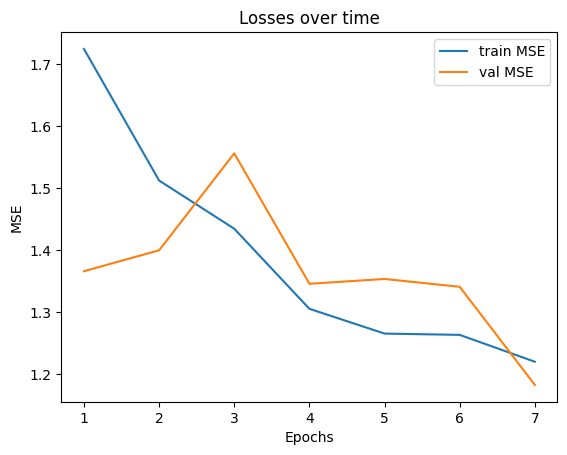

In [23]:
plt.plot(epoch_range, train_losses_np, label='train MSE')
plt.plot(epoch_range, test_losses_np, label='val MSE')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Losses over time")
plt.show()

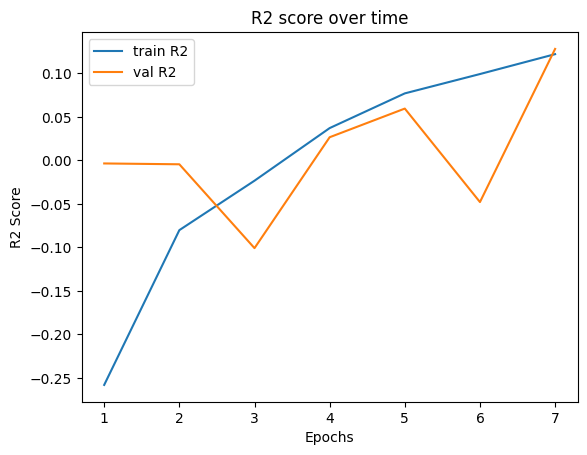

In [24]:
plt.plot(epoch_range, train_r2_np, label='train R2')
plt.plot(epoch_range, test_r2_np, label='val R2')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("R2 Score")
plt.title("R2 score over time")
plt.show()

In [25]:
# Visualize the product embeddings learned over time
embeds = model.product_embedding.weight.detach().cpu().numpy().copy() # extract embedding layer
tsne = TSNE(n_components=2, perplexity=5, random_state=seed, init='random', learning_rate=200)
fitted_dims = tsne.fit_transform(embeds)

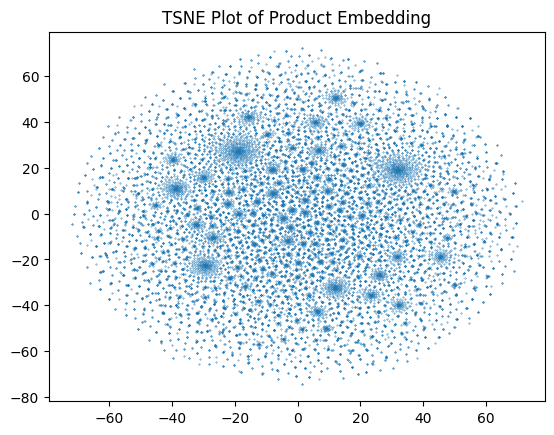

In [26]:
x_dim, y_dim = fitted_dims.T
plt.scatter(x_dim, y_dim, s=0.1)
plt.title("TSNE Plot of Product Embedding")
plt.show()